In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

There are some noticeable discrepancies between the O3 data and the titration predictions. Is it possible that this is due to the breakdown of the weak promoter approximation?

The fold-change for simple repression should be $\mathrm{fc} \approx \frac{1 + p}{1 + r_A + p}$, where $p = \frac{P}{N_{NS}}e^{-\beta \epsilon_P}$ and $r_A = \frac{R_A}{N_{NS}}e^{-\beta \epsilon_{R_A}}$. Generally, we assume that promoter binding is weak enough that it does not compete with the operator, and simplify the expression to $\mathrm{fc} \approx \frac{1}{1 + r_A}$. This tends to work pretty well, though I wonder whether the approximation holds up for weak operators like O3. In this notebook, I would like to explore this idea. 

For the RNAP binding energy I chose $\Delta \epsilon_P = -5.4$, a value I took from Manuel's paper. I chose an RNAP copy number of 3000 for growth in M9, a value estimated from the data at tinyurl.com/qlofd5.

In [2]:
# Define some parameters
IPTG = np.logspace(-8, -2, 200) * 10**6
Ka = 139
Ki = 0.53
reps = np.array([11,30,62,130,610,870])
epsilon = 4.5
O3 = -9.7
e_p = -5.4
P = 3000

In [3]:
# Here are some fold change functions for IPTG titrations, maintaining the weak promoter approximation.

def pact_log(IPTG, Ka, Ki, epsilon):
    pact = (1 + IPTG * 1 / Ka)**2 / \
    (((1 + IPTG * 1 / Ka))**2 + np.exp(-epsilon) * (1 + IPTG * 1 / Ki)**2)
    return pact

def fold_change_log(IPTG, Ka, Ki, epsilon, R, epsilon_r):
   return 1 / (1 + 2 * R / 5E6 * pact_log(IPTG, Ka, Ki, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))


# And here is a fold-change function that does not use the weak promoter approximation

def fold_change_RNAP(IPTG, Ka, Ki, epsilon, R, epsilon_r, P, e_p):
    return (1 + P / 5E6 * np.exp(-e_p))/ (1 + P / 5E6 * np.exp(-e_p) + 2 * \
            R / 5E6 * pact_log(IPTG, Ka, Ki, epsilon) * (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

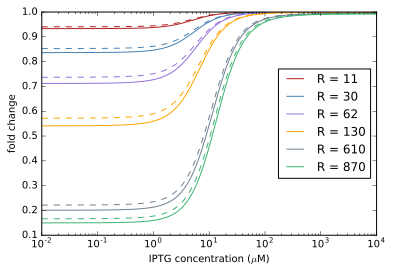

In [4]:
# Plot curves for O3

colors = ['firebrick', 'steelblue', 'mediumpurple', 'orange', 'slategray', 'mediumseagreen', 'palevioletred']
colors_dict = dict(zip(reps, colors))

for rep in reps:
    plt.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=rep, epsilon_r=O3), \
                 color=colors_dict[rep], label = ('R = %i' % rep))
    plt.semilogx(IPTG, fold_change_RNAP(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=rep, epsilon_r=O3, P=P, e_p=e_p), \
                 ls='--', color=colors_dict[rep])

plt.legend(loc='center right')
plt.xlabel(r'IPTG concentration ($\mu$M)')
plt.ylabel('fold change')

There is a noticeable discrepancy between the plots using the weak promoter approximation (solid lines) and those that don't (dashed lines), though the differences are not extreme. We would expect stronger operators to compete less with RNAP binding, and thus there should be less discrepancy between curves that use the weak promoter approximation and those that don't. 

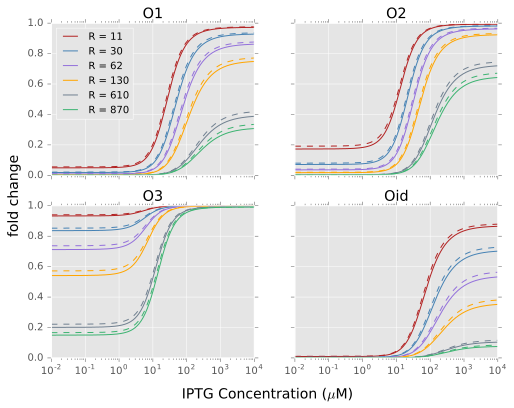

In [178]:
# Plot curves for all operators

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex=True, sharey=True)

ax = [ax1, ax2, ax3, ax4]
ops = [-15.3, -13.9, -9.7, -17.0]
labels = ['O1', 'O2', 'O3', 'Oid']
colors = ['firebrick', 'steelblue', 'mediumpurple', 'orange', 'slategray', 'mediumseagreen', 'palevioletred']

ops_dict = dict(zip(ax, ops))
labels_dict = dict(zip(ax, labels))
colors_dict = dict(zip(reps, colors))

for a in ax:
    for rep in reps:
        a.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=rep, epsilon_r=ops_dict[a]), \
                     color=colors_dict[rep], label = ('R = %i' % rep))
        a.semilogx(IPTG, fold_change_RNAP(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=rep, epsilon_r=ops_dict[a], P=P, e_p=e_p), \
                     ls='--', color=colors_dict[rep])
        a.set_title(labels_dict[a])
ax1.legend(loc=2, fontsize=10)
        
f.text(0.5, 0.04, r'IPTG Concentration ($\mu$M)', ha='center', va='center', fontsize='14')
f.text(0.06, 0.5, 'fold change', ha='center', va='center', rotation='vertical', fontsize='14')


In the curves above, the solid lines represent curves that use the approximation and the dashed lines represent curves that don't. Surprisingly, there is some discrepancy between the curves even for strong operator binding sites. For strong operator binding sites, the majority of the discrepancy appears to occur at high IPTG concentrations, when the fraction of active repressors is very small. 

These discrepancies could be cause for concern when we try growing cells in rich media, as the discrepancies become more pronounced as the RNAP copy number increases. At a doubling time of 30 min, the RNAP copy number is approximately 8000, which gives us the curves below. 

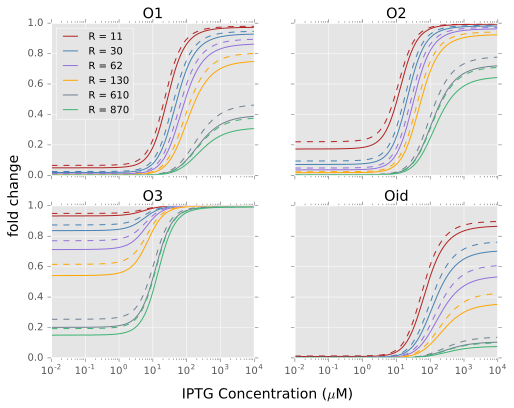

In [179]:
P = 8000

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex=True, sharey=True)

ax = [ax1, ax2, ax3, ax4]
ops = [-15.3, -13.9, -9.7, -17.0]
labels = ['O1', 'O2', 'O3', 'Oid']
colors = ['firebrick', 'steelblue', 'mediumpurple', 'orange', 'slategray', 'mediumseagreen', 'palevioletred']

ops_dict = dict(zip(ax, ops))
labels_dict = dict(zip(ax, labels))
colors_dict = dict(zip(reps, colors))

for a in ax:
    for rep in reps:
        a.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=rep, epsilon_r=ops_dict[a]), \
                     color=colors_dict[rep], label = ('R = %i' % rep))
        a.semilogx(IPTG, fold_change_RNAP(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=rep, epsilon_r=ops_dict[a], P=P, e_p=e_p), \
                     ls='--', color=colors_dict[rep])
        a.set_title(labels_dict[a])
ax1.legend(loc=2, fontsize=10)
        
f.text(0.5, 0.04, r'IPTG Concentration ($\mu$M)', ha='center', va='center', fontsize='14')
f.text(0.06, 0.5, 'fold change', ha='center', va='center', rotation='vertical', fontsize='14')


Some of the discrepancies here are quite significant, especially at high and low concentrations of IPTG. This could be important to keep in mind as we move forward with trying different growth conditions, and when consider the causes for mis-matches between theory and data. 

So, what factors would cause the O3 linear region to "broaden" the way it does? Here, I'd like to explore what each of the parameters individually does to the plot. 

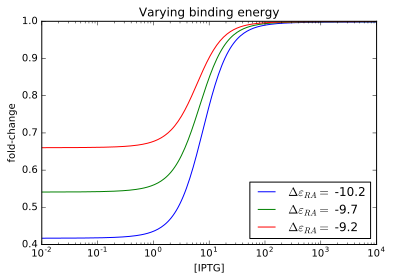

In [22]:
# Let's start by varying the binding energy
R = 130
binding_energies = [O3 - 0.5, O3, O3 + 0.5]

for en in binding_energies:
    plt.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon,\
                                       R=R, epsilon_r=en), label = (r'$\Delta \varepsilon_{RA} = $ %.1f' % en))

plt.legend(loc = 'lower right')
plt.xlabel('[IPTG]')
plt.ylabel('fold-change')
plt.title('Varying binding energy')

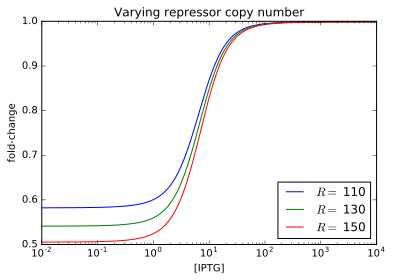

In [23]:
# Now, repressor copy number
R = 130
reps = [R - 20, R, R + 20]

for rep in reps:
    plt.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon,\
                                       R=rep, epsilon_r=O3), label = (r'$R = $ %i' % rep))

plt.legend(loc = 'lower right')
plt.xlabel('[IPTG]')
plt.ylabel('fold-change')
plt.title('Varying repressor copy number')

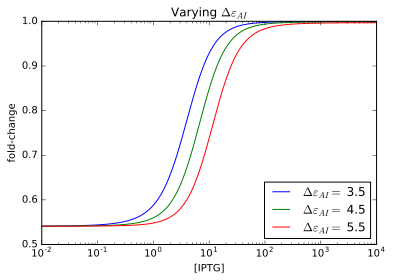

In [26]:
# Now, epsilon_AI 
R = 130
eps = [epsilon - 1.0, epsilon, epsilon + 1.0]

for ep in eps:
    plt.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=ep,\
                                       R=R, epsilon_r=O3), label = (r'$\Delta \varepsilon_{AI} = $ %.1f' % ep))

plt.legend(loc = 'lower right')
plt.xlabel('[IPTG]')
plt.ylabel('fold-change')
plt.title(r'Varying $\Delta \varepsilon_{AI}$')

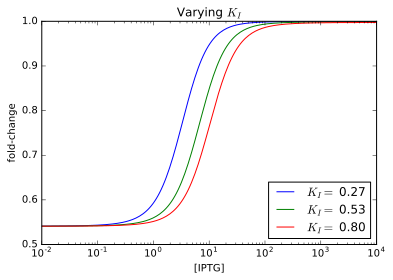

In [28]:
# Now, K_I
R = 130
K_I = [Ki - 0.5*Ki, Ki, Ki + 0.5*Ki]

for K in K_I:
    plt.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=Ka, Ki=K, epsilon=epsilon,\
                                       R=R, epsilon_r=O3), label = (r'$K_I = $ %.2f' % K))

plt.legend(loc = 'lower right')
plt.xlabel('[IPTG]')
plt.ylabel('fold-change')
plt.title(r'Varying $K_I$')

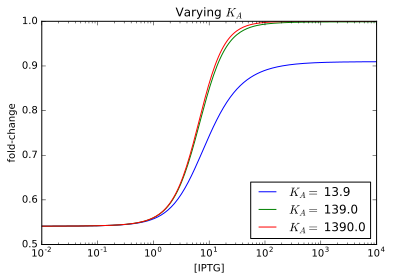

In [30]:
# Now, K_A
R = 130
K_A = [0.1*Ka, Ka, 10*Ka]

for K in K_A:
    plt.semilogx(IPTG, fold_change_log(IPTG=IPTG, Ka=K, Ki=Ki, epsilon=epsilon,\
                                       R=R, epsilon_r=O3), label = (r'$K_A = $ %.1f' % K))

plt.legend(loc = 'lower right')
plt.xlabel('[IPTG]')
plt.ylabel('fold-change')
plt.title(r'Varying $K_A$')

The result is that no individual parameter appears to affect slope alone; would have to perform a global fit to get some idea of what is going on. 